# Predictive Modeling w/ PyTorch
This notebook is a work-in-progress.

- Code to predict stock market movements with large scale technical indicator data used in PyTorch layers.
- Model choice will likely be LSTM but TBD.
- The original data is 'close' pricing and daily 'volume'. These are further extended with many technical indicators.
- The technical indicator data is then pulled for stocks that have close correlations in return with a 'given' input ticker.
- Data for several of these tickers (and their corrs) is then concatenated to construct training dataset.
- In-progress: Train and test in PyTorch NN layers

In [1]:
import os
import os.path
from datetime import datetime
from typing import Union, Any
import time
import numpy as np

import pandas as pd
from numpy.array_api import arange
from pandas.errors import EmptyDataError
from sqlalchemy import create_engine, text
from sklearn.preprocessing import MinMaxScaler

from functools import reduce

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
pd.options.mode.chained_assignment = None

/var/folders/3v/2n8y1tvs3jl2w00mdxjkf7pm0000gn/T/ipykernel_75422/503567439.py:9: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  from numpy.array_api import arange


In [2]:
BASE_DIR = '../../../../workspace/HelloPython/HistoricalMarketData/TechnicalIndicators'
TABLE_EQUITIES_DATA = 'equities_historic_data'
DURATIONS = (14, 30, 90, 200)  # Roughly for bi-weekly, monthly, quarterly, and 200 days running averages

In [3]:
try:
    DB = os.environ["DB"]
    DB_USER = os.environ["DB_USER"]
    DB_PWD = os.environ["DB_PWD"]
except KeyError:
    raise Exception("Required environment variables DB_USER and DB_PWD not set")
DB_URL = 'mysql+mysqlconnector://' + DB_USER + ':' + DB_PWD + '@localhost/' + DB
ENGINE = create_engine(DB_URL)

In [4]:
def generate_file_path(symbol, date=None):
    """
    Generates a file path for a given symbol
    to retrieve calculated tech indicator data
    from local CSV records
    :param symbol: ticker
    :param date: date embedded in the file name
    :return: file name and path
    """
    if date is not None:
        str_date = datetime.strftime(date, '%Y%m%d')
        file_name = symbol.lower() + '_' + str_date + '.csv'
    else:
        file_name = symbol.lower() + '.csv'
    file_path = os.path.join(BASE_DIR, file_name)
    if file_path is None:
        print('Could not find file for symbol:{}'.format(symbol))
    # print(file_path)
    return file_path, file_name

In [5]:
def retrieve_technical_indicator_data_for_symbol(symbol, columns = None, feature=None)\
        -> Any:
    """
    Retrieves Technical Indicator Data for a given symbol
    for given columns and labels them as Y (dependent) or
    X (input features).
    :param symbol: Symbol for which to retrieve Technical Indicator Data
    :param columns: Subset of Technical Indicator Data to retrieve
    :param feature: Y or X_i label where 'i' is feature number
    :return:
    """
    file_path, _ = generate_file_path(symbol)
    if file_path is not None:
        try:
            dfrm = pd.read_csv(file_path)
            dfrm['date'] = pd.to_datetime(dfrm['date'])
            dfrm.set_index('date', inplace=True)
            dfrm.sort_index(ascending=True)
            dfrm.index.name = 'date'
            if feature is None:
                feature = symbol.upper()
            if columns is not None:
                dfrm = dfrm[columns]
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                if column in columns
                ]
            else:
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                ]
            return dfrm
        except FileNotFoundError as e:
            print('Exception reading input data for symbol {}. Generating metadata starting from baseline date.'.format(symbol.upper()))
            return None
        except EmptyDataError as e:
            print(f'No technical indicators found for {symbol.upper()}. Generating metadata starting from baseline date.')
            print('Generating all records.')
            return None
    else:
        print(f"No technical indicators data in DB for '{symbol}'.")
    return None

tmp_df = retrieve_technical_indicator_data_for_symbol('AAPL', ['volume', 'close'])
tmp_df.tail(10)

,AAPL_volume,AAPL_close
date,,
2025-04-22,52976371,199.74
2025-04-23,52929165,204.60
2025-04-24,47310989,208.37
2025-04-25,38222258,209.28
2025-04-28,37626816,210.14
2025-04-29,36827633,211.21
2025-04-30,52286454,212.50
2025-05-01,57365675,213.32
2025-05-02,101010621,205.35


In [6]:
def find_symbols_w_highest_correlations(symbol, correlations, count):
    """
    Finds tickers whose return have highest correlation
    with the returns of given symbol
    :param symbol:
    :param correlations:
    :param count:
    :return:
    """
    if len(correlations[correlations['level_0'] == symbol.upper()+'_close']) <= 0:
        print("No correlations found for symbol:{}.".format(symbol.upper()))
        print("Likely data does not go far enough back.")
        return None
    corrs = correlations[correlations['level_0'] == symbol.upper()+'_close']
    corrs.sort_values(0, ascending = False, inplace = True)
    return_symbols = [symbol.replace('_close', '') for symbol in corrs.loc[:,'level_1'].tolist()]
    return return_symbols[0:count]

In [7]:
def gen_corrs(dfrm):
    """
    Generate correlations numbers for entire
    input dataframe consisting of daily close values
    :param dfrm:
    :return:
    """
    correlations = dfrm[dfrm.columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    #print(correlations)`
    return correlations

## Training Dataset
Generate training dataset by finding symbols that have the highest correlation (based on daily 'close' values) with the given symbol. Then aggregate their returns over the years. The daily closing price of our target symbol becomes independent variable y and rest of the data including closing values of other symbols and their volumes make up the 'features' or 'X'.

In [8]:
MIN_ROW_COUNT = 5000 # Number of days to retrieve training data for
COMP_COUNT = 10 # Number of stocks to find high correlations with

query = 'SELECT symbol FROM equities_historic_data GROUP BY symbol HAVING COUNT(*) > '+str(MIN_ROW_COUNT)+''
with ENGINE.connect() as conn:
    res = conn.execute(text(query))
dfrm_symbols_list = pd.DataFrame(res.mappings().all())
symbols = dfrm_symbols_list['symbol'].tolist() # this is our universe of symbol tickers

# First calculate universal correlations among ALL these symbols
dfrm_list_daily_closes = list()
for symbol in symbols:
    dfrm = retrieve_technical_indicator_data_for_symbol(symbol, ['close', 'volume'])
    dfrm_list_daily_closes.append(dfrm)
merged_dfrm_daily_close_values = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_daily_closes)
correlations = gen_corrs(merged_dfrm_daily_close_values)

# Now merge a symbol's returns with returns of symbols
# it has the highest correlations with. Then stack (concat)
# all these returns across symbols to come up with our
# training dataset

# Data for a symbol and its corrs matches
# Think of this as a single line in a matrix
dfrm_list_single_row_data = list()
# Data for all symbol and their corrs matches
# Think of this as a matrix
dfrm_list_full_matrix_data = list() # Data for
tgt_symbols_list = ['JPM', 'C', 'MS', 'GS', 'WFC', 'BAC'] # Generate training data for this set only
for symbol in tgt_symbols_list:
    # Our dependent variable Y - generalize the name so we can stack up many symbols for training dataset
    dfrm_symbol = retrieve_technical_indicator_data_for_symbol(symbol, None, 'Y')
    dfrm_list_single_row_data.append(dfrm_symbol)
    symbols_w_highest_corrs = find_symbols_w_highest_correlations(symbol, correlations, COMP_COUNT)
    if symbols_w_highest_corrs is None:
        continue # Likely not enough data for a symbol. Continue with rest
    print(f'Symbols with highest correlations with {symbol.upper()} are {symbols_w_highest_corrs}')
    counter = 1
    for comp_symbol in symbols_w_highest_corrs:
        feature = 'X_'+str(counter)
        dfrm_tmp = retrieve_technical_indicator_data_for_symbol(comp_symbol, None, feature)
        dfrm_list_single_row_data.append(dfrm_tmp)
        counter += 1
    # Now merge the symbol and all its corrs data against the same date
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_single_row_data)
    dfrm_list_full_matrix_data.append(merged_df)
    dfrm_list_single_row_data.clear()
# Now concatenate data. This means dates are repeated
dfrm_aggr_training_data = pd.concat(dfrm_list_full_matrix_data)

Symbols with highest correlations with JPM are ['TXN', 'PNC', 'MAR', 'SPGI', 'SCHW', 'SIVB', 'SYK', 'WM', 'RJF', 'SNPS']
Symbols with highest correlations with C are ['AIG', 'RF', 'KEY', 'ZION', 'HIG', 'HBAN', 'ARNC', 'FITB', 'KIM', 'XRX']
Symbols with highest correlations with MS are ['HIG', 'DRE', 'ZION', 'KEY', 'FITB', 'LNC', 'MGM', 'RF', 'XRX', 'MET']
Symbols with highest correlations with GS are ['BK', 'STT', 'PRU', 'NTRS', 'CMA', 'CME', 'LNC', 'CBRE', 'SCHW', 'PFG']
Symbols with highest correlations with WFC are ['USB', 'DIS', 'PPG', 'UPS', 'SNA', 'IPG', 'OMC', 'MDLZ', 'AMGN', 'WHR']
No correlations found for symbol:BAC.
Likely data does not go far enough back.


In [9]:
dfrm_single_symbol_training_data = dfrm_list_full_matrix_data[4]
dfrm_single_symbol_training_data

,Y_symbol,Y_close,Y_volume,Y_mean_200,Y_stddev_200,Y_pcntleStdDevs_200,Y_pcntleVolume_200,Y_pcntleClosing_200,Y_oscillator_200,Y_accu_dist_200,...,X_10_stddev_90,X_10_accu_dist_200,X_10_bollingerLower_200,X_10_bollingerUpper_200,X_10_mean_200,X_10_oscillator_200,X_10_pcntleClosing_200,X_10_pcntleStdDevs_200,X_10_pcntleVolume_200,X_10_stddev_200
date,,,,,,,,,,,,,,,,,,,,,
2002-02-20,WFC,22.970,8890000,21.957782,1.087244,48.120301,53.759398,75.939850,79.662921,5.616507e+06,...,2.900307,192787.319606,54.530495,76.725144,65.627820,63.616558,43.609023,47.368421,51.127820,5.548662
2002-02-21,WFC,22.875,8520000,21.964627,1.086044,46.268657,47.761194,73.880597,77.528090,5.208397e+06,...,2.905524,222302.823790,54.577250,76.689914,65.633582,65.708061,47.761194,46.268657,67.910448,5.528166
2002-02-22,WFC,23.030,7470000,21.972519,1.085862,45.925926,28.888889,78.518519,81.011236,5.858275e+06,...,2.895570,199716.880497,54.621371,76.651814,65.636593,64.139434,45.185185,45.925926,46.666667,5.507611
2002-02-25,WFC,23.300,6900000,21.959586,1.089206,50.375940,21.052632,87.593985,87.078652,7.053475e+06,...,2.886939,340260.394450,54.521475,76.671306,65.596391,73.769063,64.661654,48.872180,92.857143,5.537458
2002-02-26,WFC,23.315,7350000,21.963571,1.093211,52.631579,27.067669,87.969925,87.415730,7.121648e+06,...,2.897748,667194.117647,54.494894,76.809166,65.652030,96.209150,97.744361,54.135338,97.744361,5.578568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-29,WFC,71.100,24563554,71.636912,5.238784,NaN,93.382353,42.647059,49.510763,-8.045819e+04,...,10.567088,-598296.095588,75.759582,133.181007,104.470294,0.000000,0.735294,100.000000,91.176471,14.355356
2025-04-30,WFC,71.010,15882226,71.710588,5.157773,NaN,84.558824,41.176471,49.070450,-1.539589e+05,...,9.680139,-603249.014706,75.143738,133.372880,104.258309,0.000000,0.735294,100.000000,90.441176,14.557286
2025-05-01,WFC,71.810,19672472,71.711314,5.138782,NaN,90.510949,51.094891,52.984344,4.992517e+05,...,9.674165,-608610.401460,74.635283,133.464571,104.049927,0.000000,0.729927,NaN,88.321168,14.707322


## Data Normalization and Train-Test split

In [10]:
# Start with separating independent vector matrix (X) and dependent vector (y)
# Take care of X first
batch_size = 5
len_data = len(dfrm_single_symbol_training_data)
tgt_field_column_name = 'Y_close'
tgt_symbol_column_name = 'Y_symbol'
train_to_total_ratio = 0.8
test_to_total_ratio = 1- train_to_total_ratio

# The train and test dataset must be perfect multiple of batch size
# Try to find some API to simplify this.
offset_test_data_start = len_data - int(test_to_total_ratio * len_data)
offset_test_data_start = offset_test_data_start - (offset_test_data_start % batch_size)
offset_test_date_end = offset_test_data_start + int(test_to_total_ratio * len_data)
offset_test_date_end = offset_test_date_end - (offset_test_date_end % batch_size)

dfrm_training = dfrm_single_symbol_training_data.iloc[batch_size:offset_test_data_start, :]
dfrm_test = dfrm_single_symbol_training_data.iloc[offset_test_data_start:offset_test_date_end, :]
print(len(dfrm_training))
print(len(dfrm_test))

4650
1160


In [11]:
# x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'symbol' not in column]
x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'close' in column]
Y_train = dfrm_training[tgt_field_column_name]
X_train = dfrm_training[x_columns]
# null_indices = X_train[X_train.isnull().any(axis=1)].index
# X_train = X_train.drop(null_indices)
# Y_train = Y_train.drop(null_indices)

Y_test = dfrm_test[tgt_field_column_name]
X_test = dfrm_test[x_columns]

# Cap the numeric values within (-1, +1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler.fit_transform(Y_test.values.reshape(-1,1))

transformed_X_train = X_train.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
for column_name in X_train.select_dtypes(include=['int64', 'float64']).columns:
    transformed_X_train[column_name] = scaler.fit_transform(X_train[[column_name]])

transformed_X_test = X_test.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
for column_name in X_test.select_dtypes(include=['int64', 'float64']).columns:
    transformed_X_test[column_name] = scaler.fit_transform(X_test[[column_name]])

In [12]:
x_train = torch.from_numpy(transformed_X_train.to_numpy()).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test.to_numpy()).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

x_train_loader = DataLoader(x_train, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
y_train_loader = DataLoader(y_train, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
x_test_loader = DataLoader(x_test, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
y_test_loader = DataLoader(y_test, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction

In [13]:
x_train.shape

torch.Size([4650, 10])

In [14]:
input_dim = len(X_train.columns) # Number of features
#hidden_dim = int(len(X_train)) # Number of samples or units
hidden_dim = 512
num_layers = 2
output_dim = 1
num_epochs = 2 # Intentionally keeping low for initial debugging
seq_len = 10

## Model Definition and Predictions

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure x has batch dimension
        #print("Input size:", x.size(0))
        # print(f'X:{x}')
        x = self.dropout(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers= num_layers, output_dim=output_dim, )
criterion = torch.nn.MSELoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
model.lstm

LSTM(10, 512, num_layers=2, batch_first=True)

In [17]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    counter = 1
    for batch in x_train_loader:
        batch = batch.reshape(5, 1, input_dim)
        y_train_pred = model(batch)
        y_train_observed = next(iter(y_train_loader))
        loss = criterion(y_train_pred, y_train_observed)
        print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        # hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        counter += 1

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch:0, Batch:1, Loss: 0.8422
Epoch:0, Batch:2, Loss: 0.0063
Epoch:0, Batch:3, Loss: 5.5775
Epoch:0, Batch:4, Loss: 0.0458
Epoch:0, Batch:5, Loss: 1.2953
Epoch:0, Batch:6, Loss: 1.2147
Epoch:0, Batch:7, Loss: 0.5069
Epoch:0, Batch:8, Loss: 0.0184
Epoch:0, Batch:9, Loss: 0.2593
Epoch:0, Batch:10, Loss: 0.3838
Epoch:0, Batch:11, Loss: 0.2073
Epoch:0, Batch:12, Loss: 0.0117
Epoch:0, Batch:13, Loss: 0.1830
Epoch:0, Batch:14, Loss: 0.3797
Epoch:0, Batch:15, Loss: 0.4052
Epoch:0, Batch:16, Loss: 0.2607
Epoch:0, Batch:17, Loss: 0.0676
Epoch:0, Batch:18, Loss: 0.0047
Epoch:0, Batch:19, Loss: 0.0982
Epoch:0, Batch:20, Loss: 0.1988
Epoch:0, Batch:21, Loss: 0.1428
Epoch:0, Batch:22, Loss: 0.0245
Epoch:0, Batch:23, Loss: 0.0103
Epoch:0, Batch:24, Loss: 0.0538
Epoch:0, Batch:25, Loss: 0.0955
Epoch:0, Batch:26, Loss: 0.1080
Epoch:0, Batch:27, Loss: 0.0884
Epoch:0, Batch:28, Loss: 0.0494
Epoch:0, Batch:29, Loss: 0.0147
Epoch:0, Batch:30, Loss: 0.0016
Epoch:0, Batch:31, Loss: 0.0135
Epoch:0, Batch:32

In [18]:
# Make predictions
model.eval()
with torch.no_grad():
    for batch in x_test_loader:
        #train_predict = model(x_train)
        batch = batch.reshape(batch_size, 1, input_dim)
        test_predict = model(batch)
        print(test_predict)

tensor([[-0.4564],
        [-0.4563],
        [-0.4558],
        [-0.4559],
        [-0.4557]])
tensor([[-0.4556],
        [-0.4557],
        [-0.4563],
        [-0.4563],
        [-0.4565]])
tensor([[-0.4566],
        [-0.4565],
        [-0.4565],
        [-0.4566],
        [-0.4566]])
tensor([[-0.4567],
        [-0.4562],
        [-0.4560],
        [-0.4557],
        [-0.4555]])
tensor([[-0.4556],
        [-0.4559],
        [-0.4561],
        [-0.4567],
        [-0.4565]])
tensor([[-0.4564],
        [-0.4561],
        [-0.4563],
        [-0.4562],
        [-0.4557]])
tensor([[-0.4551],
        [-0.4550],
        [-0.4549],
        [-0.4553],
        [-0.4554]])
tensor([[-0.4552],
        [-0.4551],
        [-0.4546],
        [-0.4544],
        [-0.4549]])
tensor([[-0.4545],
        [-0.4550],
        [-0.4533],
        [-0.4533],
        [-0.4539]])
tensor([[-0.4541],
        [-0.4537],
        [-0.4536],
        [-0.4536],
        [-0.4538]])
tensor([[-0.4535],
        [-0.4533],
  

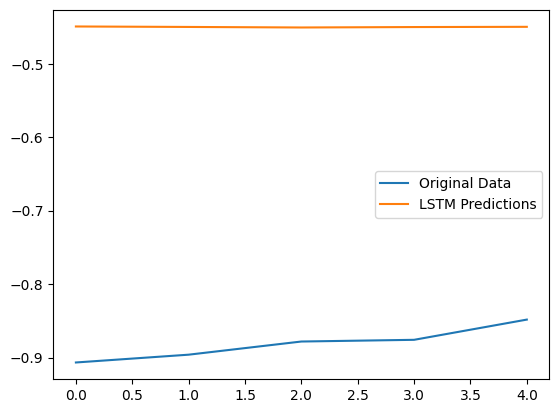

In [19]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(y_test[0:5], label='Original Data')
# plt.plot(np.concatenate((train_predict.numpy().flatten(), test_predict.numpy().flatten())), label='LSTM Predictions')
plt.plot(test_predict.numpy().flatten(), label='LSTM Predictions')
plt.legend()
plt.show()

In [20]:
x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'close' in column]
Y_train = dfrm_training[tgt_field_column_name]
X_train = dfrm_training[x_columns]
# null_indices = X_train[X_train.isnull().any(axis=1)].index
# X_train = X_train.drop(null_indices)
# Y_train = Y_train.drop(null_indices)

Y_test = dfrm_test[tgt_field_column_name]
X_test = dfrm_test[x_columns]

# Cap the numeric values within (-1, +1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler.fit_transform(Y_test.values.reshape(-1,1))

transformed_X_train = X_train.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
for column_name in X_train.select_dtypes(include=['int64', 'float64']).columns:
    transformed_X_train[column_name] = scaler.fit_transform(X_train[[column_name]])

transformed_X_test = X_test.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
for column_name in X_test.select_dtypes(include=['int64', 'float64']).columns:
    transformed_X_test[column_name] = scaler.fit_transform(X_test[[column_name]])

x_train = torch.from_numpy(transformed_X_train.to_numpy()).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test.to_numpy()).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

x_train_loader = DataLoader(x_train, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
y_train_loader = DataLoader(y_train, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
x_test_loader = DataLoader(x_test, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
y_test_loader = DataLoader(y_test, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction

input_dim = len(X_train.columns) # Number of features
#hidden_dim = int(len(X_train)) # Number of samples or units
hidden_dim = 512
num_layers = 2
output_dim = 1
num_epochs = 2 # Intentionally keeping low for initial debugging
seq_len = 10


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure x has batch dimension
        #print("Input size:", x.size(0))
        # print(f'X:{x}')
        x = self.dropout(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers= num_layers, output_dim=output_dim, )
criterion = torch.nn.MSELoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
model.lstm


hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    counter = 1
    for batch in x_train_loader:
        batch = batch.reshape(5, 1, input_dim)
        y_train_pred = model(batch)
        y_train_observed = next(iter(y_train_loader))
        loss = criterion(y_train_pred, y_train_observed)
        print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        # hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        counter += 1

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch:0, Batch:1, Loss: 1.0982
Epoch:0, Batch:2, Loss: 0.0445
Epoch:0, Batch:3, Loss: 5.5324
Epoch:0, Batch:4, Loss: 0.0089
Epoch:0, Batch:5, Loss: 1.1203
Epoch:0, Batch:6, Loss: 1.2313
Epoch:0, Batch:7, Loss: 0.7164
Epoch:0, Batch:8, Loss: 0.1862
Epoch:0, Batch:9, Loss: 0.0141
Epoch:0, Batch:10, Loss: 0.3704
Epoch:0, Batch:11, Loss: 0.2928
Epoch:0, Batch:12, Loss: 0.0033
Epoch:0, Batch:13, Loss: 0.1650
Epoch:0, Batch:14, Loss: 0.3532
Epoch:0, Batch:15, Loss: 0.3669
Epoch:0, Batch:16, Loss: 0.1684
Epoch:0, Batch:17, Loss: 0.0039
Epoch:0, Batch:18, Loss: 0.1132
Epoch:0, Batch:19, Loss: 0.1968
Epoch:0, Batch:20, Loss: 0.0799
Epoch:0, Batch:21, Loss: 0.0058
Epoch:0, Batch:22, Loss: 0.0288
Epoch:0, Batch:23, Loss: 0.0880
Epoch:0, Batch:24, Loss: 0.0999
Epoch:0, Batch:25, Loss: 0.0687
Epoch:0, Batch:26, Loss: 0.0177
Epoch:0, Batch:27, Loss: 0.0020
Epoch:0, Batch:28, Loss: 0.0261
Epoch:0, Batch:29, Loss: 0.0522
Epoch:0, Batch:30, Loss: 0.0479
Epoch:0, Batch:31, Loss: 0.0181
Epoch:0, Batch:32

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# ...

# Scale the target variable
scaler_y = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler_y.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler_y.transform(Y_test.values.reshape(-1,1))

# Scale the features
scaler_x = MinMaxScaler(feature_range=(-1, 1))
transformed_X_train = scaler_x.fit_transform(X_train)
transformed_X_test = scaler_x.transform(X_test)

# Create tensors
x_train = torch.from_numpy(transformed_X_train).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

# Create a dataset and data loader
train_dataset = TensorDataset(x_train.unsqueeze(1), y_train)  # Add sequence dimension
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# ...

# Training loop
for t in range(num_epochs):
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.reshape(-1, 1, input_dim)  # Reshape to (batch_size, seq_len, input_dim)
        y_train_pred = model(x_batch)
        loss = criterion(y_train_pred, y_batch)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        print(f'Epoch:{t+1}, Loss: {loss.item():.4f}')